# Causal Inference in Decision Intelligence – Part 17: Macroeconomic Analysis for Decision Intelligence

Link to the article:  [Macroeconomic Analysis for Decision Intelligence](https://www.coursera.org/specializations/financialengineering)

## Import libraries

In [1]:
# Import libraries
#%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import pandas_datareader.data as web
import pandas_datareader as pdr

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## Building an integrated cycle

In [2]:
# Create individual cycles 
data_cycle = pd.DataFrame({'Year': list(range(1950, 2056))})

# Kuznets generational / Real estate cycle with amplitude 30 and period 18
data_cycle['Kuznets'] = 30 * np.sin((2 * np.pi / 18) * (data_cycle.Year - 1941))

# Juglars capital investment cycle with amplitude 15 and period 9
data_cycle['Juglar'] = 15 * np.sin((2 * np.pi / 9) * (data_cycle.Year - 1948))

# Kitchin business cycle with amplitude 8 and period 4
data_cycle['Kitchin'] = 8 * np.sin((2 * np.pi / 4) * (data_cycle.Year - 1949))

# Create a short-term combination of cycles (without Kondratieff cycle)
data_cycle['Cycle_s'] = data_cycle['Kuznets']  + data_cycle['Juglar'] + data_cycle['Kitchin']

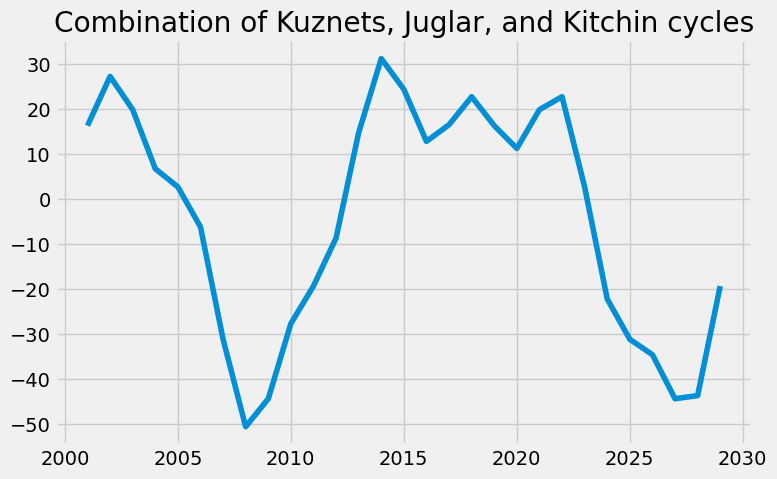

In [3]:
# Draw a short-term combination of cycles (without Kondratieff cycle)
ddf = data_cycle.query('Year>2000 and Year<2030')
fig, ax = plt.subplots(figsize=(8, 5))  
ax.plot(ddf.Year, ddf.Cycle_s)
ax.set_title("Combination of Kuznets, Juglar, and Kitchin cycles")
plt.show(); 

## Vector Autoregression model

### Load the data

In [9]:
# Load the datasets from FRED
start_date = '1978-12-01'
end_date = '2024-12-01'
data = web.DataReader(['USREC', 'IPMAN', 'W875RX1', 'CMRMTSPL', 'PAYEMS'], 
                      'fred', start_date, end_date).rename(columns={'USREC': 'Crisis', 'IPMAN': 'Indprod',
                                                                     'W875RX1': 'Income', 'CMRMTSPL': 'Sales', 
                                                                     'PAYEMS': 'Employment'})
data.index.freq = data.index.inferred_freq

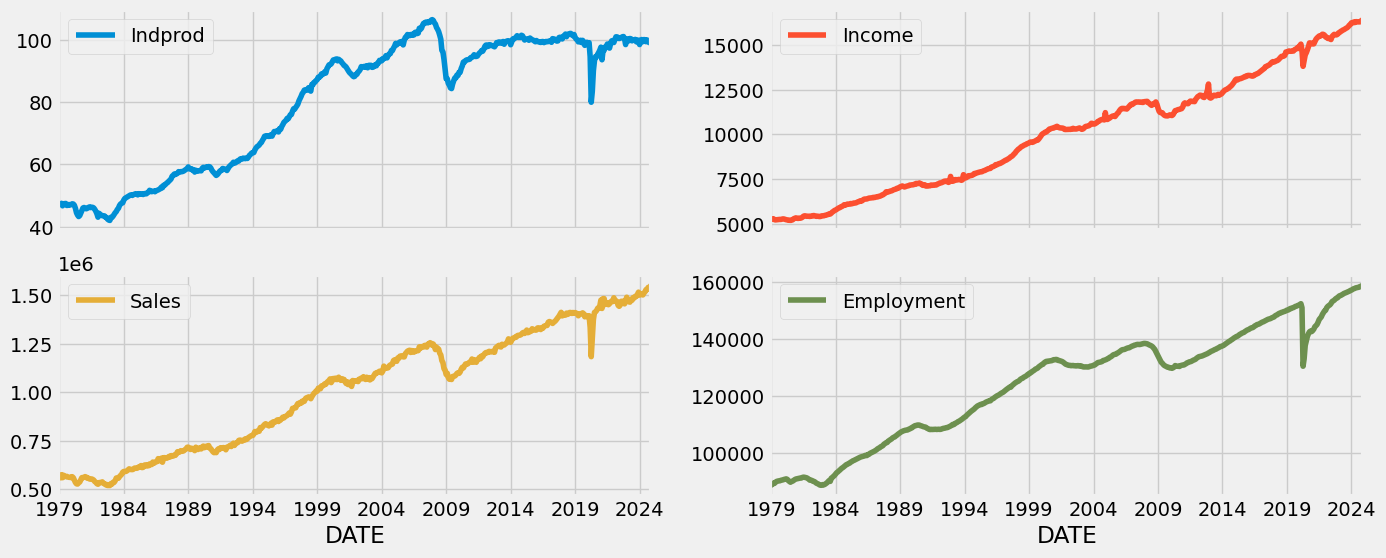

In [10]:
data.loc[:, 'Indprod':'Employment'].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

### Transform the data

In [11]:
# Create log-differenced series
data['dln_indprod'] = (np.log(data.Indprod)).diff() 
data['dln_income'] = (np.log(data.Income)).diff() 
data['dln_sales'] = (np.log(data.Sales)).diff() 
data['dln_employm'] = (np.log(data.Employment)).diff() 


### Specify Vector Autoregression model

In [12]:
# Create a dataset
df = data.loc['1979-01-01':, 'dln_indprod':'dln_employm']
# Specify and fit VAR model
model_var = VAR(df)
results = model_var.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Mar, 2025
Time:                     14:21:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -39.8937
Nobs:                     550.000    HQIC:                  -40.0656
Log likelihood:           7962.69    FPE:                3.56333e-18
AIC:                     -40.1758    Det(Omega_mle):     3.33933e-18
--------------------------------------------------------------------
Results for equation dln_indprod
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000996         0.000496            2.007           0.045
L1.dln_indprod         0.186863         0.074731            2.500           0.012
L1.dln_income          0.213758         0.077245  

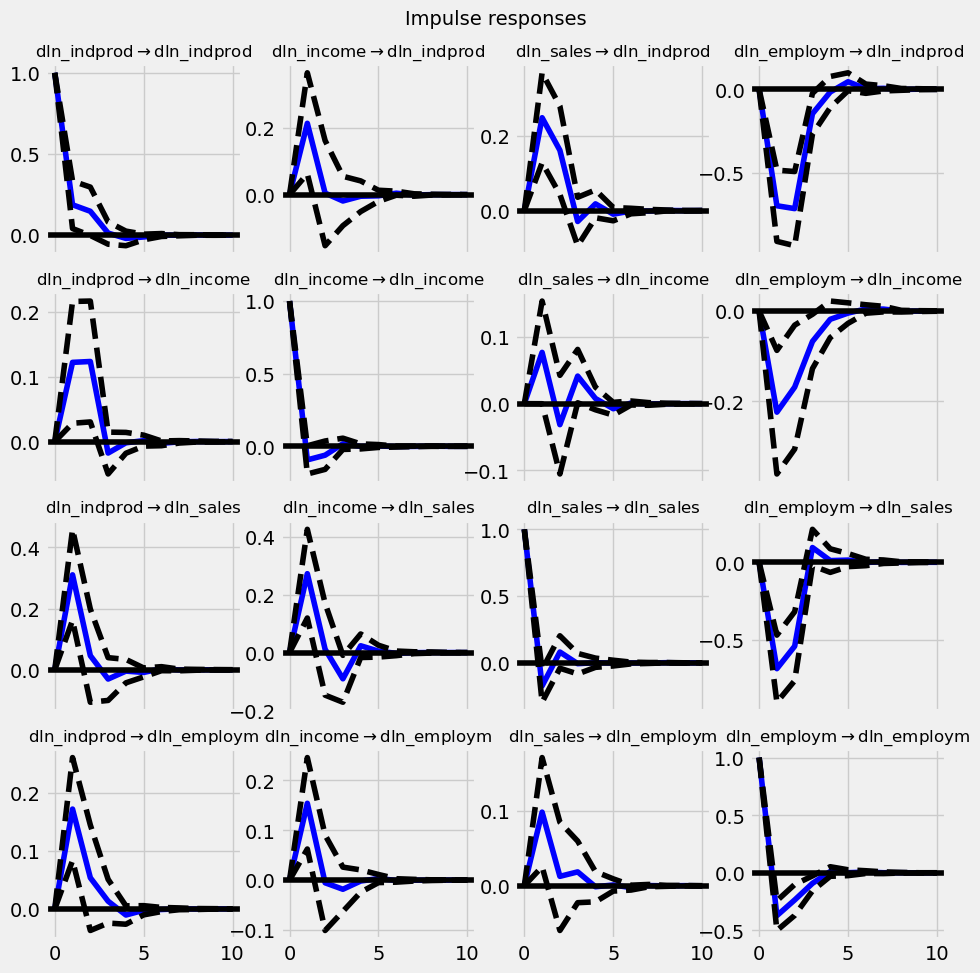

In [14]:
# Plot the impulse response functions
irf = results.irf(10)
irf.plot(orth=False);

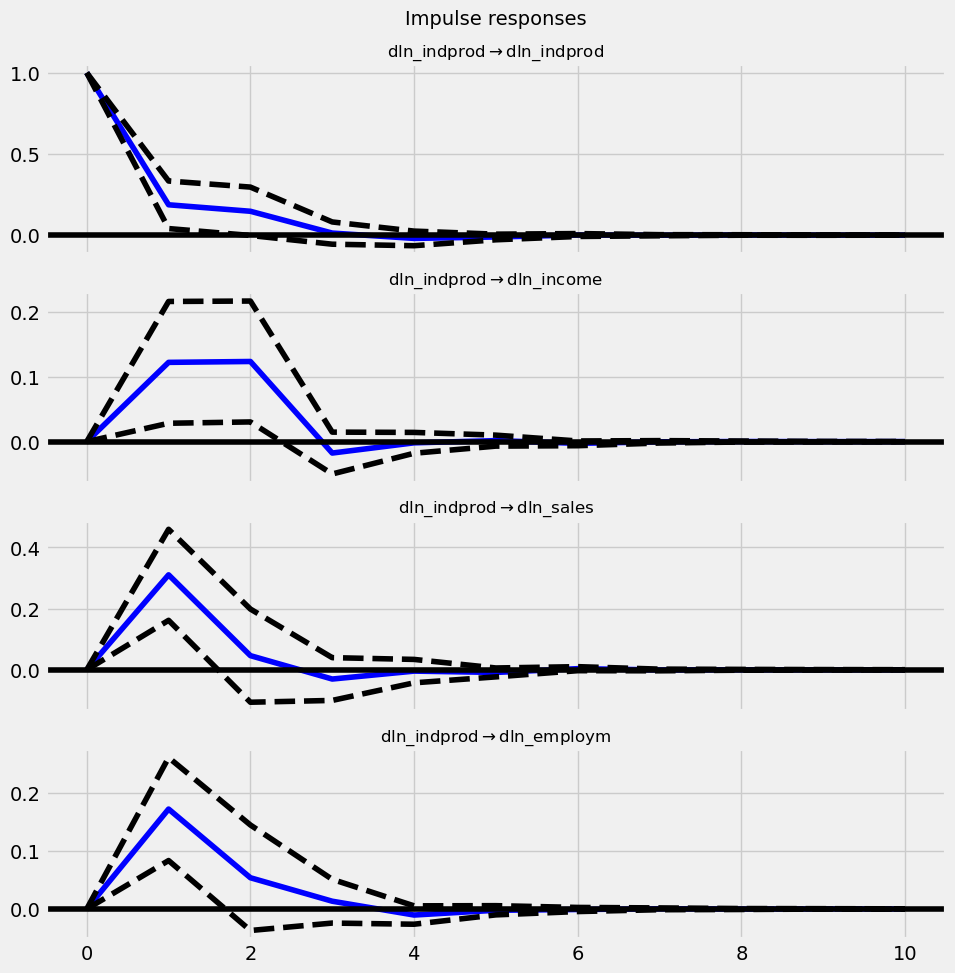

In [15]:
# Plot the impulse response functions for intervention in industrial production
irf.plot(impulse='dln_indprod');

In [16]:
# Run Granger causality test of the effect of Income and Sales on Industrial production
print(results.test_causality('dln_indprod', ['dln_income', 'dln_sales'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['dln_income', 'dln_sales'] do not Granger-cause dln_indprod: reject at 5% significance level. Test statistic: 7.943, critical value: 2.376>, p-value: 0.000>


In [17]:
# Run Granger causality test of the effect of Employment on Industrial production
print(results.test_causality('dln_indprod', ['dln_employm'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: dln_employm does not Granger-cause dln_indprod: reject at 5% significance level. Test statistic: 34.025, critical value: 3.000>, p-value: 0.000>
